# LSTM Homehelper Chatbot

## References
1. Sequence to Sequence Learning with Neural Networks https://arxiv.org/abs/1409.3215
1. PyTorch Tutorials: Chatbot Tutorial https://pytorch.org/tutorials/beginner/chatbot_tutorial.html 
1. PyTorch Tutorials: NLP From Scratch: Translation with a Sequence to Sequence Network and Attention https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html 
1. Sequence to Sequence Learning with Neural Networks https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb
1. Seq2Seq-Chatbot https://github.com/iJoud/Seq2Seq-Chatbot

## Project Overview

In this project, you will build a chatbot that can converse with you at the command line. The chatbot will use a Sequence to Sequence text generation architecture with an LSTM as it's memory unit. You will also learn to use pretrained word embeddings to improve the performance of the model. At the conclusion of the project, you will be able to show your chatbot to potential employers.

Additionally, you have the option to use pretrained word embeddings in your model. We have loaded Brown Embeddings from Gensim in the starter code below. You can compare the performance of your model with pre-trained embeddings against a model without the embeddings.



---



A sequence to sequence model (Seq2Seq) has two components:
- An Encoder consisting of an embedding layer and LSTM unit.
- A Decoder consisting of an embedding layer, LSTM unit, and linear output unit.

The Seq2Seq model works by accepting an input into the Encoder, passing the hidden state from the Encoder to the Decoder, which the Decoder uses to output a series of token predictions.

## Dependencies

- Pytorch
- Numpy
- Pandas
- NLTK
- Gzip
- Gensim


Please choose a dataset from the Torchtext website. We recommend looking at the Squad dataset first. Here is a link to the website where you can view your options:

- https://pytorch.org/text/stable/datasets.html

## Preparations

In [32]:
import gzip
import math
import random
import string
import time

from pprint import pprint
from tqdm import tqdm

import numpy as np
import pandas as pd

import torchtext
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader

import nltk
from nltk.tokenize import RegexpTokenizer

from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

Set the random seeds for deterministic results.

In [33]:
SEED = 43

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Step 1: Build your Vacabulry & create the Word Embeddings

### Step 1-1: Import the Dataset

In [35]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def loadDF(path=None):
    """
    You will use this function to load the dataset into a Pandas Dataframe for processing.
    """
    train_iter, dev_iter = torchtext.datasets.SQuAD1(root=path, split=('train', 'dev')) 

    train_dict = [{'context': context, 'question': question, 'answer': answers[0], 'indices': index} for context, question, answers, index in train_iter]
    train_df = pd.DataFrame(train_dict)

    dev_dict = [{'context': context, 'question': question, 'answer': answers[0], 'indices': index} for context, question, answers, index in dev_iter]
    dev_df = pd.DataFrame(dev_dict)

    return train_df, dev_df
  
train_df, dev_df = loadDF('data')

In [36]:
for i in range(0, 5): # first 5 Q&A
    print("> ", train_df.iloc[i].question, "\n< ", train_df.iloc[i].answer, "\n") 

>  To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? 
<  Saint Bernadette Soubirous 

>  What is in front of the Notre Dame Main Building? 
<  a copper statue of Christ 

>  The Basilica of the Sacred heart at Notre Dame is beside to which structure? 
<  the Main Building 

>  What is the Grotto at Notre Dame? 
<  a Marian place of prayer and reflection 

>  What sits on top of the Main Building at Notre Dame? 
<  a golden statue of the Virgin Mary 



### Step 1-2: Define the Vocabulary Object

In [37]:
# Default word tokens
PAD_token = "<pad>"  # Used for padding short sentences
SOS_token = "<sos>"  # Start-of-sentence token
EOS_token = "<eos>"  # End-of-sentence token
UNK_token = "<unk>"

PAD_index = 0
SOS_index = 1
EOS_index = 2
UNK_index = 3

stemmer = nltk.stem.snowball.SnowballStemmer('english')

class Vocab:
    def __init__(self):
        self.index2word = {PAD_index: PAD_token, SOS_index: SOS_token, EOS_index: EOS_token, UNK_index: UNK_token}
        self.word2index = {token: index for index, token in self.index2word.items()}
        self.word2count = {PAD_token: 0, SOS_token: 0, EOS_token: 0, UNK_token: 0}
        self.n_words = len(self.index2word)

    # Cleans our words before adding them
    def cleanText(self, text):
        text = ''.join([s for s in text if s not in string.punctuation])
        tokenizer = RegexpTokenizer(r'\w+')
        text = tokenizer.tokenize(text.lower())
        text = [stemmer.stem(w) for w in text]
        return text

    # Indexes words in our vocabulary
    def addWord(self, word: str, count: int=1) -> bool:
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = count
            self.index2word[self.n_words] = word
            self.n_words += 1
            return True
        else:
            self.word2count[word] += count
            return False

    def trim(self, min_count: int = 2):
        words2keep = [
            (word, count) for word, count in self.word2count.items() 
            if count >= min_count or word in (PAD_token, SOS_token, EOS_token, UNK_token)
        ]

        # Reinitialize dictionaries
        self.index2word = {}
        self.word2index = {}
        self.word2count = {}
        self.n_words = 0

        for word, count in words2keep:
            self.index2word[self.n_words] = word
            self.word2index[word] = self.n_words
            self.word2count[word] = count
            self.n_words += 1

### Step 1-3: Load the Vocabulary and evaluate

In [38]:
vocab = Vocab()

# Iterate through our vocabulary dataframe and add each word to the vocabulary.
print("Adding words in questions to the vocabulary...")
count = vocab.n_words
for i, r in train_df.iterrows():
    text = vocab.cleanText(r.question)
    for t in text:
        if vocab.addWord(t):
            if count % 10_000 == 0:
                print(f"\tAdding word {count}.")
            count += 1

vocab = Vocab()

print("Adding words in answers to the vocabulary...")
count = vocab.n_words
for i, r in train_df.iterrows():
    text = vocab.cleanText(r.answer)
    for t in text:
        if vocab.addWord(t):
            if count % 10_000 == 0:
                print(f"\tAdding word {count}.")
            count += 1

Adding words in questions to the vocabulary...
	Adding word 10000.
	Adding word 20000.
Adding words in answers to the vocabulary...
	Adding word 10000.
	Adding word 20000.
	Adding word 30000.


Removing the rare words decreases the feature space.

In [39]:
print("original token count:", vocab.n_words)
vocab.trim(min_count=10)
print("reduced token count:", vocab.n_words)

original token count: 33115
reduced token count: 3890


I don't want models that are silent in response to questions, so let's remove samples where the answer field is empty.

In [40]:
print(len(train_df))
train_df = train_df[train_df.question.apply(lambda x: len([t for t in vocab.cleanText(x) if t in vocab.word2index]) > 0)]
train_df = train_df[train_df.answer.apply(lambda x: len([t for t in vocab.cleanText(x) if t in vocab.word2index]) > 0)]
print(len(train_df))

87599
71524


In [41]:
print(len(dev_df))
dev_df = dev_df[dev_df.question.apply(lambda x: len([t for t in vocab.cleanText(x) if t in vocab.word2index]) > 0)]
dev_df = dev_df[dev_df.answer.apply(lambda x: len([t for t in vocab.cleanText(x) if t in vocab.word2index]) > 0)]
print(len(dev_df))

10570
8553


In [42]:
SRC_train_dataset, TRG_train_dataset  = train_df.question.values, train_df.answer.values
SRC_test_dataset, TRG_test_dataset = dev_df.question.values, dev_df.answer.values

In [43]:
print(f"Number of training samples: {len(SRC_train_dataset)}")
print(f"Number of testing samples: {len(SRC_test_dataset)}")

Number of training samples: 71524
Number of testing samples: 8553


In [44]:
BATCH_SIZE = 64

class CustomDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray, vocab: Vocab):
        self.x = x
        self.y = y
        self.vocab = vocab
        self.vocab = vocab

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx: int):
        x = self.x[idx]
        y = self.y[idx]
        
        # Tokenize
        x = self.vocab.cleanText(x)
        y = self.vocab.cleanText(y)

        # Convert words to indeces
        x = [self.vocab.word2index[w] for w in x if w in self.vocab.word2index] 
        y = [self.vocab.word2index[w] for w in y if w in self.vocab.word2index]

        # Fill 0 to make the same length.
        x = [SOS_index] + x + [EOS_index]
        y = [SOS_index] + y + [EOS_index]

        return torch.LongTensor(x), len(x), torch.LongTensor(y), len(y)


def custom_collate(data):
    src = nn.utils.rnn.pad_sequence([sample[0] for sample in data], 
                                    padding_value=vocab.word2index[PAD_token])
    src_lengths = torch.LongTensor([sample[1] for sample in data])
    trg = nn.utils.rnn.pad_sequence([sample[2] for sample in data], 
                                    padding_value=vocab.word2index[PAD_token])
    trg_lengths = torch.LongTensor([sample[3] for sample in data])
    return src, src_lengths, trg, trg_lengths

train_dataset = CustomDataset(SRC_train_dataset, TRG_train_dataset, vocab)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                              collate_fn=custom_collate)

test_dataset = CustomDataset(SRC_test_dataset, TRG_test_dataset, vocab)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                             collate_fn=custom_collate)

## Step 2: Create the Encoder

The encoder RNN iterates through the input sentence one token (e.g. word) at a time, at each time step outputting an *output* vector and a *hidden state* vector. The hidden state vector is then passed to the next time step, while the output vector is recorded. The encoder transforms the context it saw at each point in the sequence into a set of points in a high-dimensional space, which the decoder will use to generate a meaningful output for the given task.

In [45]:
class Encoder(nn.Module):
    def __init__(self, input_size: int, emb_size: int, hid_size: int, n_layers: int, dropout: float):
        super().__init__()
        
        self.hid_size = hid_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, emb_size)

        self.rnn = nn.LSTM(emb_size, hid_size, n_layers,
                           dropout=(0 if n_layers == 1 else dropout))

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, input_lengths):
        """
        src = [src len, batch size]
        input_lengths = [batch size]
        """
        embedded = self.dropout(self.embedding(src))
        # embedded = [src len, batch size, emb dim]

        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, 
                                                   enforce_sorted=False)
        # Forward pass through RNN
        outputs, (hidden, cell) = self.rnn(packed)

        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        
        # outputs = [src len, batch size, hid size * n directions]
        # hidden = [n layers * n directions, batch size, hid size]
        # cell = [n layers * n directions, batch size, hid dim]
        
        return outputs, hidden, cell

## Step 3: Create the Decoder

The decoder RNN generates the response sentence in a token-by-token fashion. It uses the encoder’s context vectors, and internal hidden states to generate the next word in the sequence. It continues generating words until it outputs an `EOS_token`, representing the end of the sentence. A common problem with a vanilla seq2seq decoder is that if we rely solely on the context vector to encode the entire input sequence’s meaning, it is likely that we will have information loss. This is especially the case when dealing with long input sequences, greatly limiting the capability of our decoder.

In [46]:
class Decoder(nn.Module):
    def __init__(self, output_size: int, emb_size: int, hidden_size: int, n_layers: int=1, dropout: float=0.1):
        super(Decoder, self).__init__()

        # Keep for reference
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = nn.Embedding(output_size, emb_size)
        self.embedding_dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_step, last_hidden, last_cell):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)

        # Forward through unidirectional RNN
        rnn_output, (hidden, cell) = self.rnn(embedded, (last_hidden, last_cell))

        # seq len and n directions will always be 1 in the decoder, therefore:
        # output = [1, batch size, hid dim]
        # hidden = [n layers, batch size, hid dim]
        # cell = [n layers, batch size, hid dim]

        rnn_output = rnn_output.squeeze(0)
        output = self.out(rnn_output)

        # Return output and final hidden state
        return output, hidden, cell

## Step 4: Combine them into a Seq2Seq Architecture

For the final part of the implemenetation, we'll implement the seq2seq model. This will handle:

* receiving the input/source sentence
* using the encoder to produce the context vectors
* using the decoder to produce the predicted output/target sentence

In [47]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_size == decoder.hidden_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, src_lengths, trg, teacher_forcing_ratio = 0.5):
        """
        src = [src len, batch size]
        src_lengths = batch size
        trg = [trg len, batch size]
        teacher_forcing_ratio is probability to use teacher forcing
        e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        """
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_size

        # Tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # Last hidden state of the encoder is used as the initial hidden state of the decoder
        _, hidden, cell = self.encoder(src, src_lengths)

        # First input to the decoder is the SOS_tokens
        decoder_input = trg[0].unsqueeze(0)
        
        for t in range(trg_len):
            # Insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            decoder_output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            # Place predictions in a tensor holding predictions for each token
            outputs[t] = decoder_output
            
            if self.training:
                # Decide if we are going to use teacher forcing or not
                teacher_force = random.random() < teacher_forcing_ratio
                
                # Get the highest predicted token from our predictions
                top1 = decoder_output.argmax(1)

                # If teacher forcing, use actual next token as next input
                # if not, use predicted token
                decoder_input = trg[t].unsqueeze(0) if teacher_force else top1.unsqueeze(0)
            else:
                top1 = decoder_output.argmax(1)
                decoder_input = decoder_output.argmax(1).unsqueeze(0).detach()
                
        return outputs

## Step 5: Train & evaluate your model

In [48]:
INPUT_SIZE = vocab.n_words
OUTPUT_SIZE = vocab.n_words
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2
N_EPOCHS = 30
CLIP = 1
TEACHER_FORCING = 0.2
LEARNING_RATE = 1e-3
MODEL_NAME = 'squad-lstm-chatbot.pt'

enc = Encoder(INPUT_SIZE, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_SIZE, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(enc, dec, device).to(device)

Next up is initializing the weights of our model. In the paper they state they initialize all weights from a uniform distribution between -0.08 and +0.08.

In [49]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3890, 256)
    (rnn): LSTM(256, 512)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(3890, 256)
    (embedding_dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(256, 512)
    (out): Linear(in_features=512, out_features=3890, bias=True)
  )
)

We also define a function that will calculate the number of trainable parameters in the model.

In [50]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters.')

The model has 7,141,170 trainable parameters.


We define our optimizer, which we use to update our parameters in the training loop.

In [51]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token.

In [52]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_index)

In [53]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in tqdm(enumerate(iterator)):
        src = batch[0].to(device)
        src_lengths = batch[1]
        trg = batch[2].to(device)
        trg_lengths = batch[3]

        optimizer.zero_grad()
        
        output = model(src, src_lengths, trg, TEACHER_FORCING)
        
        # trg = [trg len, batch size]
        # output = [trg len, batch size, vocab size]
              
        vocab_size = output.shape[-1]
        
        output = output.view(-1, vocab_size)
        trg = trg.view(-1)
        
        # output = [trg len * batch size, vocab size]
        # trg = [trg len * batch size]
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [54]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in tqdm(enumerate(iterator)):

            src = batch[0].to(device)
            src_lengths = batch[1]
            trg = batch[2].to(device)
            trg_lengths = batch[3]

            output = model(src, src_lengths, trg, 0)  # Turn off teacher forcing

            # trg = [trg len, batch size]
            # output = [trg len, batch size, vocab size]

            output_size = output.shape[-1]
            
            output = output.view(-1, output_size)
            trg = trg.view(-1)

            # trg = [trg len * batch size]
            # output = [trg len * batch size, vocab size]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [55]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

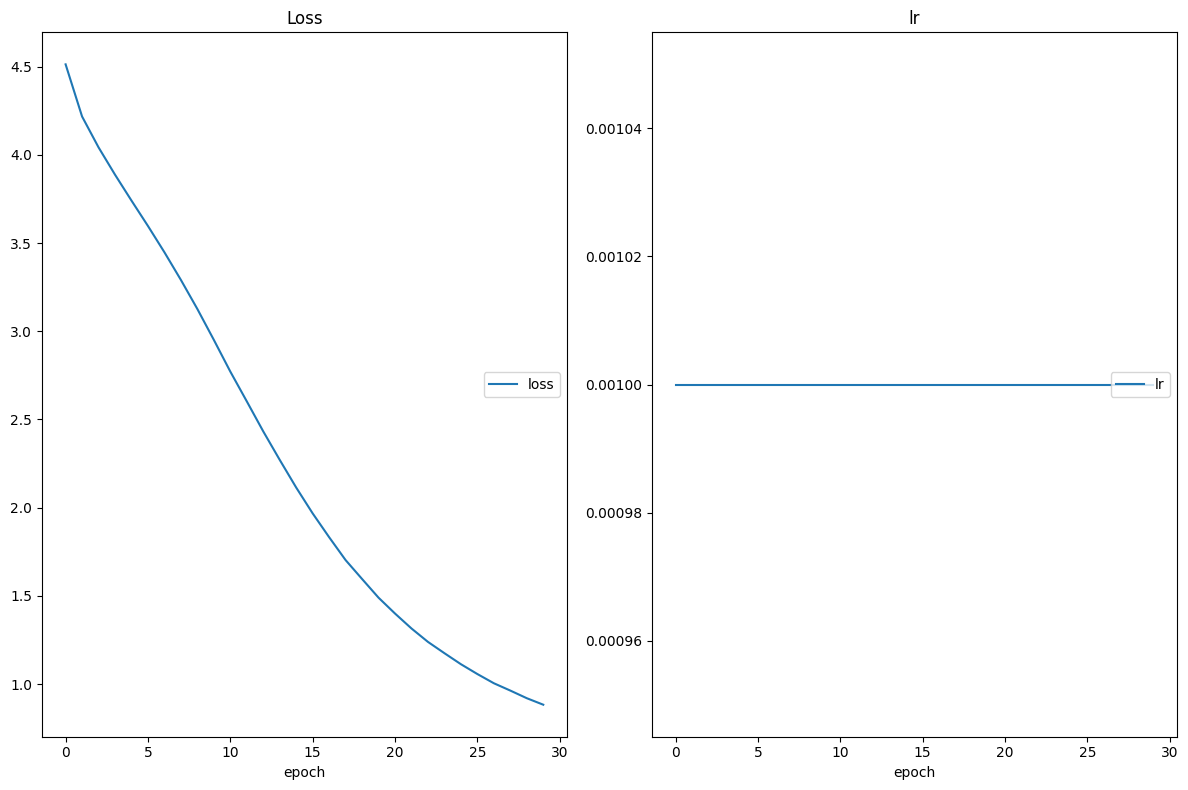

Epoch: 30/30 | Time: 0m 46s
	Train Loss: 0.883 | Train PPL:   2.417


In [56]:
best_loss = float('inf')

liveloss = PlotLosses(outputs=[MatplotlibPlot()])

logs = {}

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, iter(train_dataloader), optimizer, criterion, CLIP)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Note that step should be called after evaluate()
    # scheduler.step(valid_loss)
        
    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model.state_dict(), MODEL_NAME)

    logs["loss"] = train_loss
    logs["lr"] = optimizer.param_groups[0]["lr"]

    liveloss.update(logs)
    liveloss.send()
        
    print(f'Epoch: {epoch+1:02}/{N_EPOCHS} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')

In [57]:
model.load_state_dict(torch.load(MODEL_NAME))

test_loss = evaluate(model, iter(test_dataloader), criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

134it [00:02, 56.02it/s]

| Test Loss: 6.035 | Test PPL: 417.645 |


Reload the model file and compare some inference results with the test dataset.

In [58]:
model.load_state_dict(torch.load(MODEL_NAME))

model.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3890, 256)
    (rnn): LSTM(256, 512)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(3890, 256)
    (embedding_dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(256, 512)
    (out): Linear(in_features=512, out_features=3890, bias=True)
  )
)

In [59]:
questions = SRC_test_dataset[:10]
print(questions)
questions = [vocab.cleanText(q) for q in questions]
questions = [[vocab.word2index[w] for w in question if w in vocab.word2index] for question in questions]
questions = [torch.LongTensor([SOS_index] + question + [EOS_index]) for question in questions]
question_lengths = [len(q) for q in questions]
questions = nn.utils.rnn.pad_sequence(questions).to(device)
print(questions)

['Which NFL team represented the NFC at Super Bowl 50?'
 'Where did Super Bowl 50 take place?'
 'What color was used to emphasize the 50th anniversary of the Super Bowl?'
 'What was the theme of Super Bowl 50?' 'What day was the game played on?'
 'What is the AFC short for?' 'What was the theme of Super Bowl 50?'
 'What does AFC stand for?' 'What day was the Super Bowl played on?'
 'What venue did Super Bowl 50 take place in?']
tensor([[   1,    1,    1,    1,    1,    1,    1,    1,    1,    1],
        [ 963, 1905, 2420, 2420, 2420, 2420, 2420, 2420, 2420, 2420],
        [ 234, 1628,  555,  623,  918,  439,  623, 2531,  918, 1628],
        [2266,  378,  623,    9,  623,    9,    9, 2743,  623,  378],
        [   9,  379,  548, 2705,    9, 1412, 2705,   31,    9,  379],
        [ 394,  240,   75,    7, 1381,   31,    7,    2,  378,  240],
        [ 378,  519,    9,  378, 1087,    2,  378,    0,  379,  519],
        [ 379,   12,    7,  379,  424,    0,  379,    0, 1087,   12],
        

In [60]:
TRG_test_dataset[:10].tolist()

['Carolina Panthers',
 'Santa Clara, California',
 'gold',
 '"golden anniversary"',
 'February 7, 2016',
 'American Football Conference',
 '"golden anniversary"',
 'American Football Conference',
 'February 7, 2016',
 "Levi's Stadium"]

In [61]:
ANSWER_LENGTH = 12

answers = torch.LongTensor(np.ones((ANSWER_LENGTH, len(questions[0])))) * SOS_index
answers = model(questions, question_lengths, answers.to(device), 0)
answers = torch.argmax(answers, axis=2)
print(answers)
answers = np.transpose([[vocab.index2word[int(w)] for w in answer] for answer in answers])
answers = [' '.join(answer) for answer in answers]
pprint(answers)

tensor([[   1,    1,    1,    1,    1,    1,    1,    1,    1,    1],
        [  14,  464,  337,  942,  244,   58,  942, 1365, 1060, 1863],
        [2635,    2,    2, 3491,  201, 1978, 3491,    2,  128,  747],
        [   2,    2,    2, 3491,  412,  226, 3491,    7,    2,    2],
        [   2,    2,    2,    2,    2,   57,    2,    2,    2,    2],
        [3539,    2,    2,    2, 1098,   31,    2,    2,    2,    2],
        [   2,    2,    2,   77,    2,    9,   77,    2,    2,    2],
        [1501,    2,    2,    2,   77, 3153,    2,    2,    2,    2],
        [2069,    2,    2,    2,    5,    2,    2,    2,    2,    2],
        [ 762,    2,    2,    2,    2,    2,    2,    2,    2,    2],
        [   9,    2,    2,    2,    2, 2496,    2,    2,    2,    2],
        [1164,    2,    2,    2,    2, 2909,    2,    2,    2,    2]],
       device='cuda:0')
['<sos> and politician <eos> <eos> chelsea <eos> promot known as the field',
 '<sos> pari <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eo

## Step 6: Interact with the Chatbot

In [62]:
# print("Type 'STOP' to exit chat")
# ANSWER_LENGTH = 12

# while True:
#     inp = input(">")
    
#     # If STOP in input, stop script
#     if "STOP" == inp.strip():
#         break
    
#     # Quick error handling to account for any words not currently found in the vocabulary
#     try:
#         question = vocab.cleanText(inp)
#         question = [vocab.word2index[w] for w in question if w in vocab.word2index]
#         question = [torch.LongTensor([SOS_index] + question + [EOS_index])]
#         question_length = [len(q) for q in question]
#         question = nn.utils.rnn.pad_sequence(question).to(device)
#     except:
#         print("I could not understand this question. Please try again...")
#         continue
        
#     # Empty answer list for each word generated
#     answer = torch.LongTensor(np.ones((ANSWER_LENGTH, len(question[0])))) * SOS_index

#     # Get output - no target specified since not training
#     answer = model(question, question_length, answer.to(device), 0)
#     answer = torch.argmax(answer, axis=2)
    
#     answer = np.transpose([[vocab.index2word[int(w)] for w in a] for a in answer])
#     eos_index = answer[0].tolist().index('<eos>')
#     answer = answer[0][1:eos_index]

#     # Finally, write out answer for user
#     print("<", " ".join(answer), "\n")